**Emotion Recognition based on facial landmarks**

This part of the practical session is about **emotion recognition** based on facial landmarks. We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) to recognize the emotion of a person by analyzing 68 facial landmarks (already estimated and placed). Below, you will find a picture with an example. We will focus on two emotions neutral and happy.

Please answer all questions and complete the code where you see **XXXXXXXXXXXXX**

**Deadline**: Upload this notebook, the one about Toy Examples and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

First of all, we need to load the data. In Google Colab, we can load from Google Drive or from our local machine. Since it's faster from Google Drive, let's load them from (my) Google Drive, using the following code.

In [1]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
  dest_path='./Data_FEI.npz')
  gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
  dest_path='./facial_landmarks_68markup.jpg')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the absolute path of your working directory with the data
Working_directory="./data/data/"    

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


Otherwise, you can also load them from your local machine using the following code

In [2]:
"""
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
"""      

'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n'

Let's load the Python packages containing the functions needed for the practical session.

In [3]:
import numpy as np
from time import time

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
# this is needed to plot figures within the notebook
%matplotlib inline 
np.random.seed(seed=666)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

We also load a user-defined function useful for plotting the confusion matrix

In [4]:
# Code from scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.min()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Now, let's load the data. 

We have a list of images, the position of the original landmarks (aligned to the images), the position of the landmarks after a normalization process called Generalized Procrustes Analysis (please refer to https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis), the outputs with the class labels and the names of the images.

Generalized Procrustes Analysis (GPA) is used to keep only shape differences between the configurations of landmarks. That is to say, we align all configurations to an average one using only rigid transformations (uniform scaling, rotation and translation). This means that if I take a facial picture of subject A, then step back, translate and rotate a bit the camera and retake a facial picture of the same subject (who has not moved) the two pictures will be different with therefore different landmark position. However, after a GPA, the two landmark configurations should be perfectly aligned removing the "nuisance" differences related to rotation, translation and uniform scaling.

In [5]:
# Parameters
dim=2 # dimension   
# Loading data
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    X = data['Landmarks_FEI'] # original landmarks   
    XGPA = data['Landmarks_FEI_GPA'] # landmarks after GPA (Generalized Procrustes Analysis, https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis)
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = X.shape # number subjects 
M = int(M/2) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

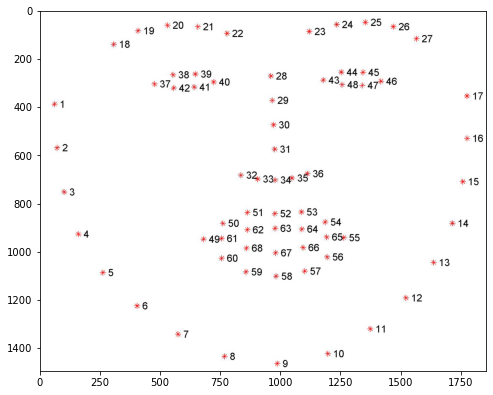

In [6]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (8,8)) # Size of the plot
plt.imshow(Example)
plt.show()

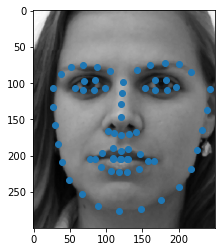

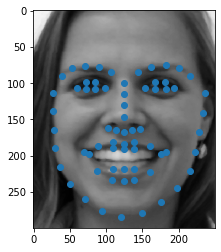

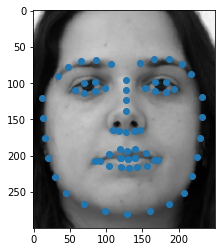

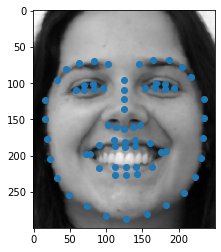

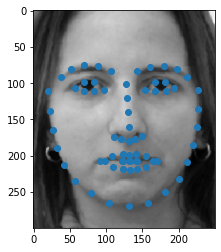

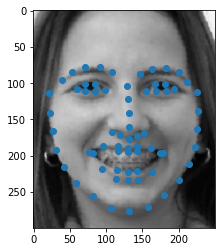

In [7]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Images[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()



---



**Question**: after plotting the first 6 images of the data-set, what do you notice ? Do you notice a regular pattern ? Do you think that it would be worth it to randomly shuffle the data ?




---



On remarque que pour des images consécutives on retrouve les même personnes, ainsi il faudrait melanger les données pour avoir un échantillon qui représente bien une population aléatoire.

In [8]:
# Shuffle data randomly. Hint: Use np.random.shuffle
i=np.random.randint(100)
np.random.seed(i)
# Use as new variables
XpGPA=np.random.permutation(XGPA)
np.random.seed(i)
Xp=np.random.permutation(X)
np.random.seed(i)
Yp=np.random.permutation(Y)
np.random.seed(i)
Imagesp=np.random.permutation(Images)
Xmean = np.mean(XpGPA,axis=0) # Compute average
np.random.seed(i)
Namesp=np.random.permutation(Names)



---



Among the loaded data, we also have aligned landmarks after a Generalized Procrustes Analysis. Let's check them and compare them with the landmarks before alignement.


**QUESTION**: Please comment the results. What can you notice ?





In the following, we will use the landmarks after GPA (*XpGPA*)




---



Text(0.5, 1.0, 'Landmarks BEFORE alignement (GPA)')

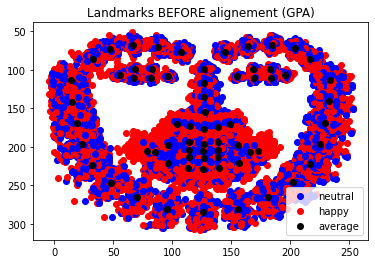

In [72]:
# Plot all landmarks BEFORE GPA
plt.figure()
for i in range(0,N):
    landmark=Xp[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
Xaverage = np.mean(Xp,axis=0) # Compute average
average=plt.scatter(Xaverage[::2],Xaverage[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis() 
plt.title('Landmarks BEFORE alignement (GPA)')

Text(0.5, 1.0, 'Landmarks AFTER alignement (GPA)')

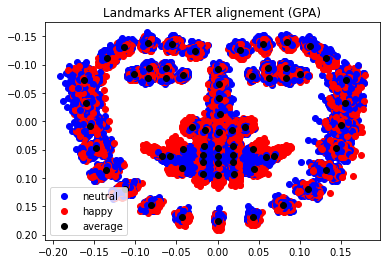

In [73]:
# Plot all landmarks AFTER GPA
plt.figure()
for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
average=plt.scatter(Xmean[::2],Xmean[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis()   
plt.title('Landmarks AFTER alignement (GPA)')

**Réponse** : On voit que GPA a permit d'aligner les landmarks et de réduire la distance entre eux. Grâce à cela on observe les classes qui se distinguent mieux. En effet on remarque bien la classe "happy" avec un sourire et "neutral" avec un visage sans sourire. 



---


We need now to compute some features for the classification algorithms. As first idea, we could use the paired Euclidean distances between the (aligned) landmarks of every subject and the landmarks of the average configuration. Please remember to use XpGPA.



---



In [74]:
# Compute distances from the average configuration (features)
dist_average=np.zeros((N,M))
for i in range(N):
    dist_average[i]= ((XpGPA[i][::2]-Xmean[::2])**2+(XpGPA[i][1::2]-Xmean[1::2])**2)**0.5
print(dist_average)

[[0.02820553 0.02521015 0.02364902 ... 0.00954105 0.00784056 0.00552658]
 [0.01531759 0.0100348  0.00649472 ... 0.00168127 0.00171237 0.00523372]
 [0.00655782 0.00490713 0.00310621 ... 0.00327217 0.00352116 0.00329574]
 ...
 [0.01628484 0.01342886 0.01283588 ... 0.01052215 0.01094722 0.01048312]
 [0.00502358 0.00561194 0.00732237 ... 0.00999388 0.00934379 0.00895059]
 [0.00510353 0.00282666 0.00508411 ... 0.00573877 0.00358412 0.00400862]]


---

**Question**: One usual question in Machine Learning is, do we need to scale/normalize the features ? What do you think ? Should we do it in this case ? Compute both scaled and normalized data.

---

**Réponse** : En général on normalise ou on "scale" les features pour éviter le fait qu'il y ait des features exprimées en dimensions non proportionnelles (ex: une en km et une en cm) qui biaiserait l'importance relative des features. Or ici il s'agit de distances à la moyenne décrites de la même façon et donc il n'y a pas ce soucis.

In [75]:
# Scale data (each feature will have average equal to 0 and unit variance)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
scaler.fit(dist_average)
dist_average_scale=scaler.transform(dist_average)

# Normalize data (each feature will be scaled into the range 0,1)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
normalizer = MinMaxScaler()
normalizer.fit(dist_average)
dist_average_norm = normalizer.transform(dist_average)

Let's divide the data-set into Training and Test sets using original, scaled and normalized data.

In [76]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(dist_average, np.ravel(Yp), test_size=0.33, random_state=42)

X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(dist_average_scale, np.ravel(Yp), test_size=0.33, random_state=42)

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(dist_average_norm, np.ravel(Yp), test_size=0.33, random_state=42)



---



Let's try to fit LDA to all training sets and predict the error on their respective test sets. 

**Question**: Compare the performnces between original, scaled and normalized data. Comment the results.



---



Fitting LDA to training set
done in 0.006s
              precision    recall  f1-score   support

           0       0.52      0.64      0.58        59
           1       0.64      0.52      0.58        73

    accuracy                           0.58       132
   macro avg       0.58      0.58      0.58       132
weighted avg       0.59      0.58      0.58       132

Normalized confusion matrix
[[0.6440678  0.3559322 ]
 [0.47945205 0.52054795]]


<Figure size 432x288 with 0 Axes>

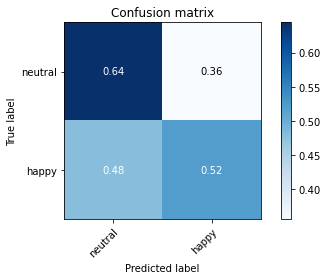

In [77]:
# Fitting LDA to original data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Fitting LDA to training set
done in 0.011s
              precision    recall  f1-score   support

           0       0.52      0.64      0.58        59
           1       0.64      0.52      0.58        73

    accuracy                           0.58       132
   macro avg       0.58      0.58      0.58       132
weighted avg       0.59      0.58      0.58       132

Normalized confusion matrix
[[0.6440678  0.3559322 ]
 [0.47945205 0.52054795]]


<Figure size 432x288 with 0 Axes>

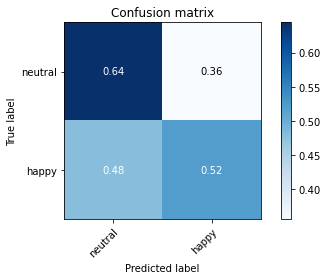

In [78]:
# Fitting LDA to scaled data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_sc, y_train_sc)
y_pred_sc = lda.predict(X_test_sc)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test_sc, y_pred_sc))

# Compute confusion matrix
cnf_matrix_sc = confusion_matrix(y_test_sc, y_pred_sc)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_sc, classes=class_names, normalize=True)
plt.show()

Fitting LDA to training set
done in 0.012s
              precision    recall  f1-score   support

           0       0.52      0.64      0.58        59
           1       0.64      0.52      0.58        73

    accuracy                           0.58       132
   macro avg       0.58      0.58      0.58       132
weighted avg       0.59      0.58      0.58       132

Normalized confusion matrix
[[0.6440678  0.3559322 ]
 [0.47945205 0.52054795]]


<Figure size 432x288 with 0 Axes>

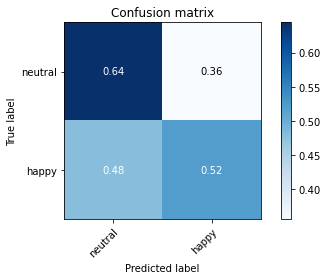

In [79]:
# Fitting LDA to normalized data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_n, y_train_n)
y_pred_n = lda.predict(X_test_n)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test_n, y_pred_n))

# Compute confusion matrix
cnf_matrix_n = confusion_matrix(y_test_n, y_pred_n)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_n, classes=class_names, normalize=True)
plt.show()

**Réponse** :Anisi les résultats sont les mêmes pour les données originelles que pour les données normalisées et "scaled". Cela confirme donc ce qui a été dit précedemment. Il n'y a pas de nécessité à changer l'échelle des données. On remarque cependant qu'il y a une grande proportion de faux positif et de faux négatif




---



We can then use the function 'cross_val_score' to compute the CV score. Let's use all methods seen today. 

**Question**: compare the performances between original, scaled and normalized data



---






In [80]:
# Cross-validation for Model Assessment
Xs=[dist_average,dist_average_scale, dist_average_norm]
Xstring=["original data","scaled data", "normalized data"]
for i in range(3):
    print("\n\nCross validation with",Xstring[i])
    # Fitting LDA
    print("Fitting LDA")
    t0 = time()
    lda = LinearDiscriminantAnalysis()
    lda_score = cross_val_score(lda,X=Xs[i], y=np.ravel(Yp),cv=5)
    print("done in %0.3fs" % (time() - t0))
    print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

    # Fitting QDA
    print("Fitting QDA")
    t0 = time()
    qda = QuadraticDiscriminantAnalysis()
    qda_score = cross_val_score(qda,X=Xs[i], y=np.ravel(Yp),cv=5)
    print("done in %0.3fs" % (time() - t0))
    print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

    # Fitting Logistic-regression
    print("Fitting Logistic Regression")
    t0 = time()
    logit = LogisticRegression(solver='lbfgs')
    logit_score = cross_val_score(logit,X=Xs[i], y=np.ravel(Yp),cv=5)
    print("done in %0.3fs" % (time() - t0))
    print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

    # Fitting Naive-Bayes
    print("Fitting Naive-Bayes")
    t0 = time()
    GNB = GaussianNB()
    GNB_score = cross_val_score(GNB,X=Xs[i], y=np.ravel(Yp),cv=5)
    print("done in %0.3fs" % (time() - t0))
    print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

    # Fitting K-nearest neighbour
    print("Fitting K-nearest neighbour")
    t0 = time()
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh_score = cross_val_score(neigh,X=Xs[i], y=np.ravel(Yp),cv=5)
    print("done in %0.3fs" % (time() - t0))
    print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))



Cross validation with original data
Fitting LDA
done in 0.077s
 Average and std CV score : 0.5599999999999999 +- 0.05086747487343949
Fitting QDA
done in 0.029s
 Average and std CV score : 0.5975 +- 0.04358898943540674
Fitting Logistic Regression
done in 0.035s
 Average and std CV score : 0.5475 +- 0.07516648189186455
Fitting Naive-Bayes
done in 0.014s
 Average and std CV score : 0.6050000000000001 +- 0.06451743950281971
Fitting K-nearest neighbour
done in 0.085s
 Average and std CV score : 0.5975 +- 0.03984344362627307


Cross validation with scaled data
Fitting LDA
done in 0.044s
 Average and std CV score : 0.5599999999999999 +- 0.05086747487343949
Fitting QDA
done in 0.041s
 Average and std CV score : 0.5975 +- 0.04358898943540674
Fitting Logistic Regression
done in 0.230s
 Average and std CV score : 0.5399999999999999 +- 0.050249378105604474
Fitting Naive-Bayes
done in 0.020s
 Average and std CV score : 0.6050000000000001 +- 0.06451743950281971
Fitting K-nearest neighbour
done in 

**Réponse** : Le changement d'echelle n'a pas de gros impact, cela modifie un peu les résultats pour la méthode "logistic regression" mais seulement sur cette méthode. Pour la méthode LDA cela parait logique puisqu'elle présuppose que les classes ont la même matrice de covariance. Pour les autres méthodes il n'y étonnamment a pas de réel changement. Ici la meilleure méthode semble être Naive Bayes et KNN.



---



In the previous example we have fixed the hyper-parameter K to 3. We coudl use CV to find the best value.



---



The best K is 7  with an average validation score equal to  0.65


Text(0, 0.5, 'CV Validation Score')

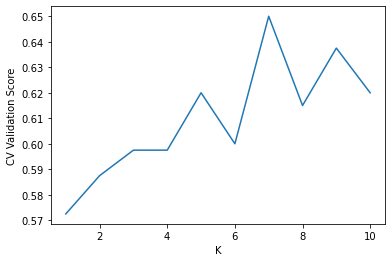

In [81]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(dist_average, np.ravel(Yp))

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')



---



We could also use CV to assess the prediction error (generalization error) in a left-out test set.



---



The best K is 9  with an average validation score equal to  0.611530398322851
The test score is 0.6287878787878788


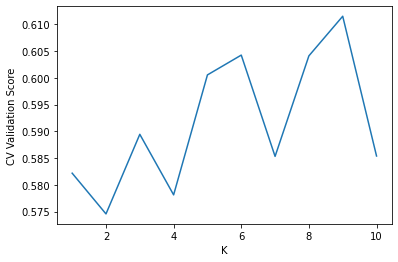

In [82]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))

**Question** : Comment the results of the two previosu experiments. What about the best K and validation error ? Are the results the same ? Why in your opinion ?

Pour la première expérience on a appliqué une cross validation sur l'ensemble des données (train+test). Ce qui nous donne un bon score mais on ne peut pas le tester avec d'autres données car elles ont été utilisées pour la cross validation. Ainsi le score obtenu peut être biaisé car il ne s'agit pas réellement d'un score sur un testset. La deuxième expérience applique la cross validation uniquement sur le trainset, ainsi on peut vérifier ensuit si on ne fait pas de l'overfitting en calculant un score avec le "vrai" testset. 

Les résultats sont différents, peut-être que K=7 est bien adapté aux données d'entrée qu'on a mais pas pour d'autres données générales. Ainsi il est préférable d'utiliser le résultat de la deuxième expérience car on est sûr d'avoir un score de 0.62 sur le testset même si le meilleure score calculé pendant la cross validtion est plus élevé pour la première expérience. 



---



It seems that these features do not work very well... let's try to change them.
We can use the distances between all combinations of landmarks. Each subject has M*(M-1)/2 features.



---



In [94]:
# Use distances between all combinations of landmarks. Each subject has M*(M-1)/2 features
dist_combination=np.zeros((N,int((M*(M-1)/2))))

for i in range(N):
    dist=[]
    for l in range(0,2*M,2):
        for m in range(0,l,2):
            dist.append(((XpGPA[i][l]-XpGPA[i][m])**2+(XpGPA[i][l+1]-XpGPA[i][m+1])**2)**0.5)
    dist_combination[i]=dist
    
print(dist_combination)

[[0.03750248 0.07512062 0.03773327 ... 0.06426945 0.02920165 0.01534179]
 [0.04498353 0.08747717 0.04256109 ... 0.05798466 0.02972595 0.01515732]
 [0.039597   0.07784582 0.03826304 ... 0.0812481  0.03818466 0.0198363 ]
 ...
 [0.03814609 0.07640919 0.03827598 ... 0.0705746  0.03240604 0.01556245]
 [0.04160315 0.08336522 0.04177411 ... 0.08203563 0.04423627 0.02159407]
 [0.03957664 0.07606789 0.03663182 ... 0.07932846 0.03349773 0.01850442]]


**Question**: As before, should we scale/normalize the data ?

**Réponse** : Oui il faudrait normaliser les données car ici les features peuvent avoir des proportions différentes car on ne calcule plus les distances par rapport à un point fixe mais les distances des landmarks entre eux. Ainsi certaines distances entre deux landmarks très différents vont être plus élevées sans qu'elles aient plus d'importance ce qui pose un problème. Il faut donc normliser ou au moins "scale" les données pour éviter ces biais.

**Question**: Use the classification algorithms seen before to test the discriminative power of the new features. 

In [101]:
normalizer = MinMaxScaler()
normalizer.fit(dist_combination)
dist_combination_norm = normalizer.transform(dist_combination)

In [98]:
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_combination_norm, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_combination_norm, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_combination_norm, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_combination_norm, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_combination_norm, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.707s
 Average and std CV score : 0.9174999999999999 +- 0.02179449471770337
Fitting QDA


C:\Users\mokar\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mokar\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mokar\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mokar\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mokar\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


done in 0.324s
 Average and std CV score : 0.605 +- 0.05787918451395114
Fitting Logistic Regression
done in 0.332s
 Average and std CV score : 0.9724999999999999 +- 0.020000000000000025
Fitting Naive-Bayes
done in 0.067s
 Average and std CV score : 0.9475 +- 0.014577379737113247
Fitting K-nearest neighbour
done in 0.782s
 Average and std CV score : 0.9424999999999999 +- 0.014999999999999977


**Réponse** : On obtient de très bons résultats avec ces features sauf pour QDA.



---



mmmm it seems that some variables are collinear. Collinearity means that one variable can be linearly predicted by the others, basically it means that there is redundancy. 

**Question**: Which technique could you use to reduce the collinearity/redundancy ? Use it and test the new features.




---



**Réponse** : On peut utiliser PCA pour garder les features avec le plus d'importance et d'information.

In [113]:
from sklearn.decomposition import PCA
pca = PCA(random_state=1)
Ypca=pca.fit_transform(dist_combination_norm)
var_explained_pca=pca.explained_variance_ratio_
index_95 = np.where(np.cumsum(var_explained_pca)>0.95)[0][0]
if index_95%2 ==1: #pour avoir un nombre de feature pair car il s'agit de points (x,y) donc de paires de feature
    index_95=index_95+1
print("New number of features :",index_95)
dist_combination_PCA = Ypca[:,:index_95]

New number of features : 16


**Question**: Test the predictive power of the new features

In [114]:
# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_combination_PCA, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_combination_PCA, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_combination_PCA, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_combination_PCA, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_combination_PCA, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.011s
 Average and std CV score : 0.9650000000000001 +- 0.01457737973711328
Fitting QDA
done in 0.006s
 Average and std CV score : 0.9625 +- 0.015811388300841892
Fitting Logistic Regression
done in 0.036s
 Average and std CV score : 0.975 +- 0.02091650066335192
Fitting Naive-Bayes
done in 0.005s
 Average and std CV score : 0.96 +- 0.01999999999999998
Fitting K-nearest neighbour
done in 0.023s
 Average and std CV score : 0.93 +- 0.01695582495781315




---


A second solution, would be to manually select few landmarks



---



In [107]:
# Select lateral landmarks mouth
select_land=[49,50,60,55,54,56]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

Number of subjects N is:  400  ; number of features is:  12


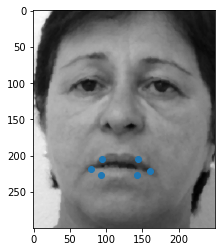

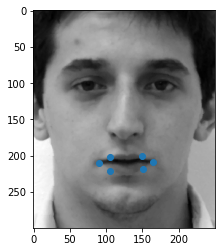

In [108]:
# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

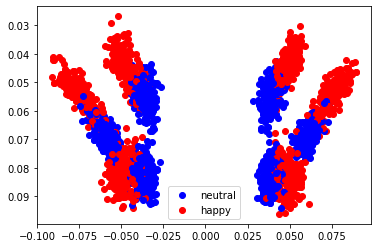

In [109]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [110]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.9550000000000001 +- 0.006434768838116886
 Average and std test score : 0.95 +- 0.023717082451262844


---

Let's plot some images where the best model was wrong. 

---

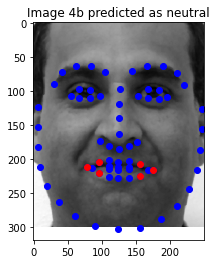

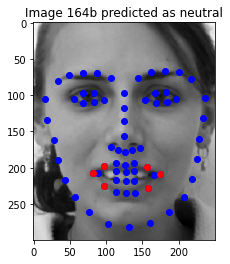

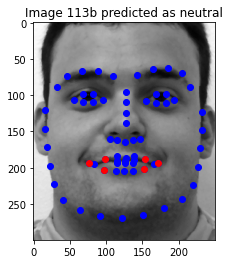

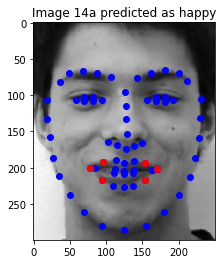

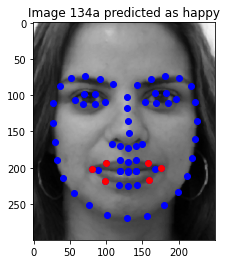

In [111]:
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()
 


**Question**: Comment the results. Why did the algorithm make a mistake ? Would you choose other landmarks ? Try at least another combination of landmarks

On remarque sur le graphe des landmarks supperposés que les classes sont assez distinctes, les landmarks décrivent une disposition différente selon la classe. Or il reste des erreurs. Ceux qui sont prédits comme "neutral" alors qu'ils n'appartiennent pas à cette classe sont des sourires qui ne sont pas prononcés, ainsi avec les seuls 6 landmarks qu'on a cela detecte comme la classe "netral". Pour l'erreur inverse, il s'agit de personnes qui ont des bouches grandes et donc les landmarks décrivent une forme proche de celle de la classe "happy".

On pourait utiliser d'autres landmarks mais surtout on pourrait ajouter tous ceux de la bouche et/ou ceux des yeux car on plisse les yeux quand on sourit. Cependant je pense que ces 6 landmarks sont ceux qui sont le plus significatifs pour décrire les classes

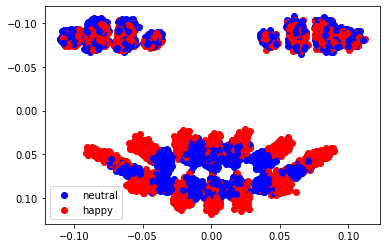

In [128]:
# Select lateral landmarks mouth and eyes
select_land2=[i for i in range(49,61)]+[i for i in range(37,49)]
indeces_central2=[]
for k in range(0,len(select_land)):
    indeces_central2.append(select_land2[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central2.append(select_land2[k]*2-1)
    
indeces_central2=np.array(indeces_central2,dtype=int)
Ms2=int(len(indeces_central2)/2) 
Xps2=np.zeros((N,Ms2*dim))
XpsGPA2=np.zeros((N,Ms2*dim))
for i in range(0,N):
    XpsGPA2[i,:]=XpGPA[i,indeces_central]
    Xps2[i,:]=Xp[i,indeces_central]   
Yps2=Yp

plt.figure()
for i in range(0,N):
    landmark=XpsGPA2[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [129]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA2, y=np.ravel(Yps2), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA2)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps2)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.9818749999999999 +- 0.006373774391990993
 Average and std test score : 0.95 +- 0.013693063937629145


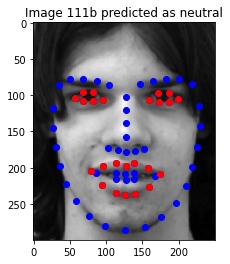

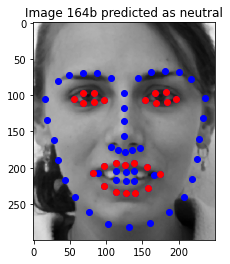

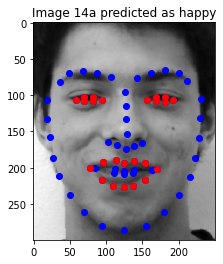

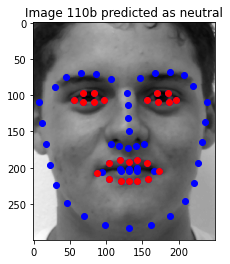

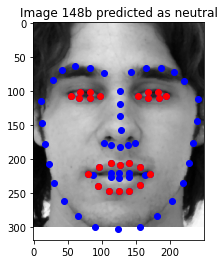

In [130]:
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps2[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob')
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()
 

Honnetement je trouve que les erreurs detectées viennent des Y initiaux car d'après moi ceux qui ont été prédit "happy" ont l'air de sourir et ceux qui ont été prédits "neutral" semblent avoir un visage neutre. Les résultats quantitatifs ont l'air d'être mieux sur le trainset mais sans changement sur testset.




---


Here, we use Nested Cross-Validation for finding the generalization error and the best K value



---



In [133]:
# Fitting K-nearest neighbour with Nested Cross-Validation
 
print("Fitting K-nearest neighbour with Nested CV")
t0 = time()
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666) # we fix the random state to always have the same results if we relaunch the code
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=neigh, param_grid=parameters, cv=inner_cv)
nested_CV = cross_validate(estimator=clf, X=XpsGPA, y=np.ravel(Yps), cv=outer_cv,return_train_score=True, return_estimator=True, n_jobs=-1)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv train score : {0} +- {1}".format(nested_CV['train_score'].mean(), nested_CV['train_score'].std() ))
print("Average and std Nested Cv test score : {0} +- {1}".format(nested_CV['test_score'].mean(), nested_CV['test_score'].std() ))

Fitting K-nearest neighbour with Nested CV
done in 0.543s
Average and std Nested Cv train score : 0.965625 +- 0.007395099728874512
Average and std Nested Cv test score : 0.9575000000000001 +- 0.02573907535246752


---

**Question**: Are Training and Test scores similar ? What does it mean ?

---

**Réponse** : Les training scores sont légérement plus élevés que pour les test scores ce qui montre un leger overfitting mais cela reste très raisonnable. On peut donc conclure que cette méthode avec ce set de features fonctionne bien pour des données plus générales, autres que celle du training. Elle a un bon pouvoir de généralisation.

**Question (OPTIONAL)**: Please propose at least another set of features using landmarks and/or pixel intensities of the images and test its discriminative power